In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras import backend
import tensorflow as tf
import keras

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
reacx = ['H2', 'H2O', 'CO', 'CO2', 'CH2O', 'CH4', 'CH3OH', 'C2H2', 'CH3CHO',
       'C2H4', 'C2H6', 'CH3COCH3', 'A1-C6H6', 'C5H6', 'A2-C10H8', 'A1OH-C6H6O',
       'LVG-C6H10O5', 'HMFU-C6H6O3', 'C5H4O2', 'C2H2O2', 'HAA-C2H4O2',
       'XYLOSE-C5H8O', 'C11H12O4', 'C8H10O3', 'COUMARYL-C9H', 'C2H5OH',
       'HCOOH']

In [4]:
reacd = {reacx[i]:i for i in range(len(reacx))}

In [5]:
import joblib
scaler1 = joblib.load('xscaler.sav')
scaler2 = joblib.load('yscaler.sav')

In [6]:
def scaler(x,y,mode=0):
    if mode==0:
        x = scaler1.fit_transform(x)
        y = scaler2.fit_transform(y.reshape(-1,y.shape[-1])).reshape(y.shape)
        
    else:
        x = scaler1.transform(x)
        y = scaler2.transform(y.reshape(-1,y.shape[-1])).reshape(y.shape)
        
    return x,y

In [7]:
fil = np.load('data_submit.npz')
xx = fil['xtest']
yy = fil['ytest']

print(xx.shape,yy.shape)

(9, 28) (9, 100, 27)


In [8]:
xtest,ytest = scaler(xx,yy,1)

In [9]:
model = keras.models.load_model('model.h5')

In [10]:
def predict(xx,yy):
    pred = model.predict(xx)
    yval = scaler2.inverse_transform(yy.reshape(-1,yy.shape[-1])).reshape(yy.shape)
    xval = scaler1.inverse_transform(xx)
    pval = scaler2.inverse_transform(pred.reshape(-1,pred.shape[-1])).reshape(pred.shape)
    pval[pval<0] = 0
    
    return xval,yval,pval,pred

In [11]:
testx,testy,testp,testpr = predict(xtest,ytest)
print(testx.shape,testy.shape,testp.shape,testpr.shape)

(9, 28) (9, 100, 27) (9, 100, 27) (9, 100, 27)


In [12]:
xtik = np.linspace(0,5,100)
xtik1 = np.linspace(0,5,20)
temps = [1073,1173,1273]
col = ['red','goldenrod','blue']
linestyles = ['solid','dashdot','dotted']
markers = ['*','o','v']

In [13]:
def plot_evolution(axs,i,j,sp):
    for k,temp in enumerate(temps):
        s = np.random.choice(np.where(testx[:,0]==temp)[0])
        axs[i,j].plot(xtik,testy[s,:,sp],c=col[k],linewidth=3,linestyle=linestyles[k])
        axs[i,j].scatter(xtik1,testp[s,::5,sp],marker=markers[k],c=col[k],s=50)
        
    axs[i,j].set_title(f'{reacx[sp]}',fontsize='18')
    plt.setp(axs[i,j].get_xticklabels(), fontsize=16)
    plt.setp(axs[i,j].get_yticklabels(), fontsize=16)

In [18]:
def plotgrid(name='',save=0):
    fig,axs = plt.subplots(2,3,figsize=(15,8))
    plot_evolution(axs,0,0,reacd['CO'])
    plot_evolution(axs,0,1,reacd['CO2'])
    plot_evolution(axs,0,2,reacd['CH4'])
    plot_evolution(axs,1,0,reacd['A1-C6H6'])
    plot_evolution(axs,1,1,reacd['A2-C10H8'])
    plot_evolution(axs,1,2,reacd['A1OH-C6H6O'])
    fig.text(0.5, -0.04, 'Time[s]', va='center', ha='center', fontsize='22')
    fig.text(-0.03, 0.5, 'Concentration', va='center', ha='center', rotation='vertical', fontsize='22')
    legend0 = plt.figlegend(predicted_lines,[str(temp-273) for temp in temps],loc='lower center',fontsize='18',ncol=3,title='Predicted [\u2103]',
              bbox_to_anchor = (0.75,-0.20),bbox_transform = plt.gcf().transFigure )
    legend1 = plt.figlegend(actual_lines,[str(temp-273) for temp in temps],loc='lower center',fontsize='18',ncol=3,title='Actual [\u2103]',
              bbox_to_anchor = (0.25,-0.20),bbox_transform = plt.gcf().transFigure )
    plt.setp(legend0.get_title(),fontsize='18')
    plt.setp(legend1.get_title(),fontsize='18')
    
    fig.gca().add_artist(legend0)
    fig.gca().add_artist(legend1)
    fig.tight_layout()
    if save:
        plt.savefig('results/{}.eps'.format(name),bbox_inches='tight',dpi=800)
    plt.show()

In [19]:
from matplotlib.lines import Line2D
predicted_lines = [Line2D([0], [0], color=col[i], marker=markers[i],linestyle='None',markersize=10) for i in range(len(col))]
actual_lines = [Line2D([0],[0],color=col[i],linestyle=linestyles[i],lw=2) for i in range(len(col))]

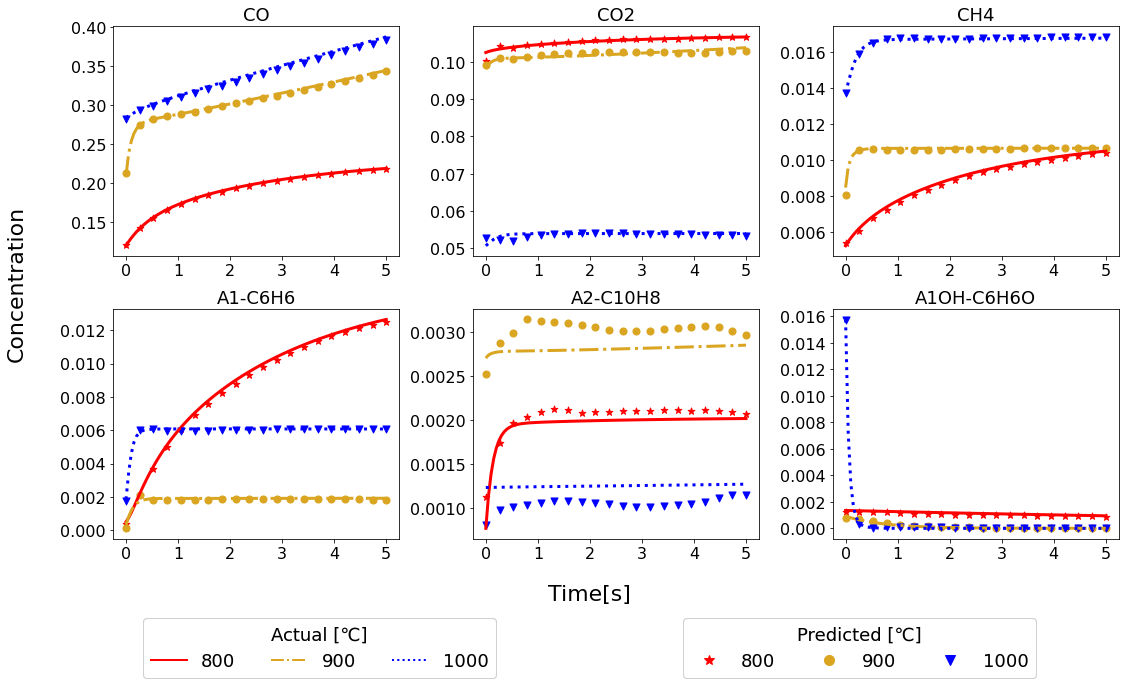

In [20]:
plotgrid(name='evolution',save=0)